# Paired T-test

In [1]:
append_dict_path = "/datadrive/ruohan/final_results_list/append.dict"
residual_dict_path = "/datadrive/ruohan/final_results_list/residual.dict"

In [4]:
import scipy.stats as stats
import sys
sys.path.insert(0, '../active_metric_learning/')
from util import obj_reader
import numpy as np

In [16]:
def paired_t_test(path):
    results = obj_reader(path)
    baseline = results["baseline_nrbp"]
    model = results["model_nrbp"]
    base_list = np.array(list(baseline.values()))
    model_list = np.array(list(model.values()))
    statistic, p_value = stats.ttest_rel(model_list, base_list)
    print("Avg: Baseline {} Model {}".format(np.mean(base_list), np.mean(model_list)))
    print("T-statistic {} Two-sided p-value {}".format(statistic, p_value))
    print("One-sided p-value {}".format(p_value/2))

In [19]:
def test_append_residual(append_dict_path, residual_dict_path):
    append = np.array(list(obj_reader(append_dict_path)["model_nrbp"].values()))
    residual = np.array(list(obj_reader(residual_dict_path)["model_nrbp"].values()))
    statistic, p_value = stats.ttest_rel(residual, append)
    print("Avg: Append {} Residual {}".format(np.mean(append), np.mean(residual)))
    print("T-statistic {} Two-sided p-value {}".format(statistic, p_value))
    print("One-sided p-value {}".format(p_value/2))


In [24]:
print("Append vs. Baseline")
paired_t_test(append_dict_path)

Append vs. Baseline
Avg: Baseline 0.6852111699318101 Model 0.82544224058361
T-statistic 62.78156732211389 Two-sided p-value 0.0
One-sided p-value 0.0


In [25]:
print("Residual vs. Baseline")
paired_t_test(residual_dict_path)

Residual vs. Baseline
Avg: Baseline 0.6852111699318101 Model 0.8338437585651999
T-statistic 59.16810117664033 Two-sided p-value 0.0
One-sided p-value 0.0


In [26]:
print("Append vs. Residual")
test_append_residual(append_dict_path, residual_dict_path)

Append vs. Residual
Avg: Append 0.82544224058361 Residual 0.8338437585651999
T-statistic 5.2885123007282955 Two-sided p-value 1.2499395341008478e-07
One-sided p-value 6.249697670504239e-08


# Analyze probability of retrieval

In [33]:
import matplotlib.pyplot as plt

In [29]:
residual_results = obj_reader(residual_dict_path)
baseline_dict = residual_results['baseline_nrbp']
residual_dict = residual_results['model_nrbp']

In [30]:
diff_dict = {}
for qid, nrbp in residual_dict.items():
    diff_dict[qid] = nrbp-baseline_dict[qid]

In [135]:
diff_list = list(diff_dict.values())
sum(np.array(diff_list)>=0)

11864

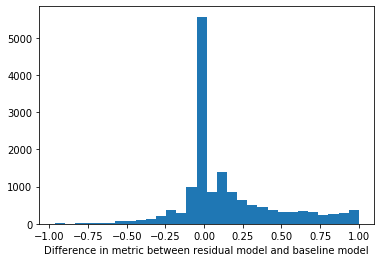

In [80]:
plt.hist(diff_list, bins=30)
plt.xlabel("Difference in metric between residual model and baseline model")
plt.show()

## Zipf's Law Plot

In [44]:
from testing import load_true_dict, delete_zeros
results = obj_reader("/datadrive/ruohan/final_evaluation/no_active_residual_50000_query_200000_passage.dict")

In [43]:
true_dict_100 = load_true_dict(k=100)

In [140]:
def plot_zipf_log(results, true_dict):
    baseline_rank = results["forward_baseline_rank_test"]
    residual_rank = results["pred_rank_test"]  
    n = len(baseline_rank)
    base = []
    model = []
    true = []
    for pid, ranks in baseline_rank.items():
        base.append(np.log(max(len(delete_zeros(ranks)),1)))
        model.append(np.log(max(1,len(delete_zeros(residual_rank[pid])))))
        true.append(np.log(max(1,len(true_dict.get(pid, [])))))
    base = sorted(base, reverse=True)
    model = sorted(model, reverse=True)
    true = sorted(true, reverse=True)
    x_rank = [np.log(i) for i in range(1,n+1)]
    plt.plot(x_rank, true, label="Ground Truth Exposing Queries")
    plt.plot(x_rank, model, label="Exposing Queries Retrieved by Residual Model")
    plt.plot(x_rank, base, label="Exposing Queries Retrieved by Baseline Model")
    plt.hlines(np.log(100), np.log(1), np.log(n), linestyles='dashed', label="log(100)")
    plt.xlabel("log(rank)")
    plt.ylabel("log(count)")
    plt.legend()
    plt.savefig("log_log.pdf", dpi=1200)
    plt.show()

In [138]:
def plot_zipf(results, true_dict):
    baseline_rank = results["forward_baseline_rank_test"]
    residual_rank = results["pred_rank_test"]  
    n = len(baseline_rank)
    base = []
    model = []
    true = []
    for pid, ranks in baseline_rank.items():
        base.append(len(delete_zeros(ranks)))
        model.append(len(delete_zeros(residual_rank[pid])))
        true.append(len(true_dict.get(pid, [])))
    base = sorted(base, reverse=True)
    model = sorted(model, reverse=True)
    true = sorted(true, reverse=True)
    x_rank = [i for i in range(1,n+1)]
    plt.plot(x_rank, true, label="Ground Truth Exposing Queries")
    plt.plot(x_rank, model, label="Exposing Queries Retrieved by Residual Model")
    plt.plot(x_rank, base, label="Exposing Queries Retrieved by Baseline Model")
    plt.xlabel("Rank")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

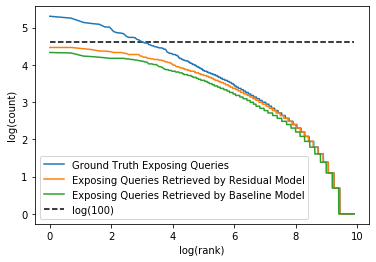

In [141]:
plot_zipf_log(results, true_dict_100)

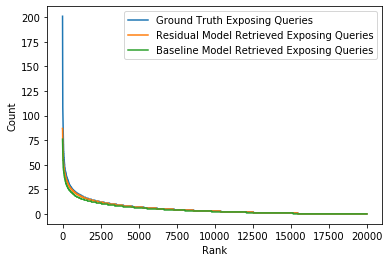

In [69]:
plot_zipf(results, true_dict_100)

# Analysis on exposing queries characteristics

In [85]:
from collections import Counter

In [82]:
def load_tsv_dict(path):
    with open(path) as file:
        line = file.readline()
        my_dict = {}
        while line:
            tokens = line.split("\t")
            indexid = int(tokens[0])
            text = tokens[1].rstrip()
            my_dict[indexid] = text
            line = file.readline()
    return my_dict

In [83]:
# Process all queries in the query log 
# to form bucket data
QUERIES_TEXT_PATH = "/datadrive/jianx/data/queries.train.tsv"
queries_text_dict = load_tsv_dict(QUERIES_TEXT_PATH)

In [104]:
def set_to_counter(query_len_dict, set_q):
    len_dict = Counter()
    for q in set_q:
        len_dict[query_len_dict[q]] += 1
    return len_dict

In [127]:
def plot_a_line(ex_dict, q_len_dict, label, cutoff=100):
    ex_dict = {k: v for k, v in sorted(ex_dict.items(), key=lambda item: item[0])}
    xaxis = []
    yaxis = []
    for length, count in ex_dict.items():
        if q_len_dict[length] < cutoff:
            continue
        xaxis.append(length)
        yaxis.append(count/q_len_dict[length])
    plt.plot(xaxis, yaxis, label=label)

In [128]:
def plot_query_length(queries_text_dict, results, true_dict, n):
    q_len_dict = Counter()
    query_len_dict = {}
    for qid, query in queries_text_dict.items():
        q = query.strip().split(" ")
        q_len_dict[len(q)] += 1
        query_len_dict[qid] = len(q)
    q_len_dict = {k: v for k, v in sorted(q_len_dict.items(), key=lambda item: item[0])}
    print(q_len_dict)
    baseline_rank = results["forward_baseline_rank_test"]
    residual_rank = results["pred_rank_test"]
    exposing_qs = set()
    base_qs = set()
    model_qs = set()
    for pid, qids in baseline_rank.items():
        base_q = list(qids.keys())[:n]
        model_q = list(residual_rank[pid].keys())[:n]
        base_qs.update(base_q)
        model_qs.update(model_q)
        true_q = true_dict.get(pid, None)
        if true_q:
            true_qq = list(true_q.keys())
            exposing_qs.update(true_qq)
    print(len(exposing_qs), len(base_qs), len(model_qs))
    expose_dict = set_to_counter(query_len_dict, exposing_qs)
    base_dict = set_to_counter(query_len_dict, base_qs)
    model_dict = set_to_counter(query_len_dict, model_qs)
    plot_a_line(expose_dict, q_len_dict, "Probability of exposing")
    plot_a_line(model_dict, q_len_dict, "Probability of retrieval by Residual model")
    plot_a_line(base_dict, q_len_dict, "Probability of retrieval by Baseline model")
    plt.legend()
    plt.xlabel("Query Length")
    plt.ylabel("Probability")
    plt.show()

{1: 35, 2: 16545, 3: 63354, 4: 117889, 5: 145157, 6: 135318, 7: 109186, 8: 79361, 9: 53216, 10: 33570, 11: 20557, 12: 12845, 13: 7928, 14: 4763, 15: 2998, 16: 1998, 17: 1257, 18: 817, 19: 540, 20: 308, 21: 304, 22: 187, 23: 141, 24: 117, 25: 80, 26: 55, 27: 48, 28: 38, 29: 29, 30: 20, 31: 16, 32: 14, 33: 13, 34: 5, 35: 2, 36: 5, 37: 3, 38: 4, 39: 1, 40: 1, 41: 1, 44: 1, 49: 1, 50: 1, 75: 1, 373: 1}
101282 120490 135883


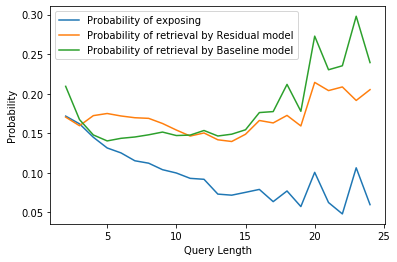

In [129]:
plot_query_length(queries_text_dict, results, true_dict_100, 10)

{1: 35, 2: 16545, 3: 63354, 4: 117889, 5: 145157, 6: 135318, 7: 109186, 8: 79361, 9: 53216, 10: 33570, 11: 20557, 12: 12845, 13: 7928, 14: 4763, 15: 2998, 16: 1998, 17: 1257, 18: 817, 19: 540, 20: 308, 21: 304, 22: 187, 23: 141, 24: 117, 25: 80, 26: 55, 27: 48, 28: 38, 29: 29, 30: 20, 31: 16, 32: 14, 33: 13, 34: 5, 35: 2, 36: 5, 37: 3, 38: 4, 39: 1, 40: 1, 41: 1, 44: 1, 49: 1, 50: 1, 75: 1, 373: 1}
101282 292539 345711


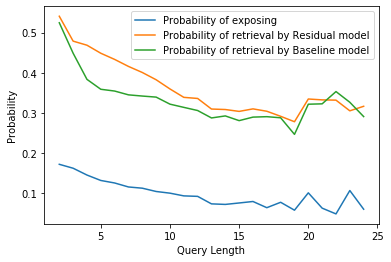

In [133]:
plot_query_length(queries_text_dict, results, true_dict_100, 50)

## Position of Exposing Queries